# Preliminary script for SCG Analysis for AR Water Age Project

In [1]:
# conda update -n base -c defaults conda

In [6]:
# !conda install -c conda-forge plotnine --y

import pandas as pd
import numpy as np
import csv as csv
import re
import os
from plotnine import *

from glob import glob

In [7]:
dir = f'/Users/hannahgreenwald/Documents/Documents/Berkeley_Research/AR_metagenomics/scg'

# Loading data to transform in pandas

In [35]:
files = glob(f'{dir}/*scg_taxonomy.txt')

In [36]:
# which reads went into which assemblies
assem_dict = {
    'ARSTAG_ARBF_1_post':["ARSTAG_AR_1_40", "ARSTAG_AR_1_41","ARSTAG_BF_1_40","ARSTAG_BF_1_41"],
    'ARSTAG_ARBF_2_post':["ARSTAG_AR_2_40", "ARSTAG_AR_2_41","ARSTAG_BF_2_40","ARSTAG_BF_2_41"],
    'ARSTAG_ARBF_3_post':["ARSTAG_AR_3_40", "ARSTAG_AR_3_41","ARSTAG_BF_3_40","ARSTAG_BF_3_41"],
    'ARSTAG_ARBF_4_post':["ARSTAG_AR_4_40", "ARSTAG_AR_4_41","ARSTAG_BF_4_40","ARSTAG_BF_4_41"],
    'ARSTAG_ARBF_5_post':["ARSTAG_AR_5_40", "ARSTAG_AR_5_41","ARSTAG_BF_5_40","ARSTAG_BF_5_41"],
    'ARSTAG_ARBF_12345_pre':["ARSTAG_AR_1_23", "ARSTAG_AR_1_27", "ARSTAG_AR_2_23", "ARSTAG_AR_2_27", "ARSTAG_AR_3_23", "ARSTAG_AR_3_27", "ARSTAG_AR_4_23", "ARSTAG_AR_5_23", "ARSTAG_AR_5_27"],
    'ARSTAG_AR_4_27':["ARSTAG_AR_4_27"],
    'ARSTAG_TAPRES_TAPRES_23':["ARSTAG_TAPRES_TAPRES_23"],
    'ARSTAG_TAPRES_TAPRES_27':["ARSTAG_TAPRES_TAPRES_27"],
    'ARSTAG_TAPRES_TAPRES_40':["ARSTAG_TAPRES_TAPRES_40"],
    'ARSTAG_TAPRES_TAPRES_41':["ARSTAG_TAPRES_TAPRES_41"],
    'ARSTAG_CONTROL_BFSLIDECONTROL_41':["ARSTAG_CONTROL_BFSLIDECONTROL_41"],
    'ARSTAG_CONTROL_MANIFB_41':["ARSTAG_CONTROL_MANIFB_41"],
    'ARSTAG_CONTROL_MOCK1E10_111821':["ARSTAG_CONTROL_MOCK1E10_111821"],
    'ARSTAG_CONTROL_MOCK1E8_111821':["ARSTAG_CONTROL_MOCK1E8_111821"]}


In [37]:
tax_df = []

for file in files:
    sample_id = os.path.basename(file)
    sample_id = re.match(r'(.*)_scg_taxonomy.txt', sample_id).groups()[0]
    mappings = assem_dict[sample_id]
    df = pd.read_csv(file, sep='\t')

    keep = ['scg_name', 'percent_identity', 't_domain', 't_phylum', 't_class',
       't_order', 't_family', 't_genus', 't_species']
    keep.extend(mappings)
    
    df = df[keep]
    df.insert(1, 'assembly', sample_id)
    tax_df.append(df)

tax_df = pd.concat(tax_df)

# save table for use in R
tax_df.to_csv(f'{dir}/tax_df.csv', index=False)

# Making plots in python

In [38]:
# drop this extra column we added
tax_df = tax_df.drop(columns='assembly')

In [39]:
ids = ['scg_name', 'percent_identity', 't_domain', 't_phylum', 't_class',
       't_order', 't_family', 't_genus', 't_species']

# normalize to calculate relative abundance based on the sum of coverages of all RPS2 proteins in each sample
# we first remove the id columns since they aren't numerical, then merge them back on afterward

tax_df_abund = tax_df.drop(columns=ids).copy()
tax_df_abund.index = tax_df['scg_name']
tax_df_abund = tax_df_abund.replace(np.nan, 0)
tax_df_abund = 100*tax_df_abund.div(tax_df_abund.sum())
tax_df_abund = tax_df_abund.reset_index()
tax_df_abund = tax_df_abund.merge(tax_df[ids], how='left')

In [40]:
# melt data to long format for plotting
tax_df_abund_melt = tax_df_abund.melt(id_vars=ids, value_name='coverage', var_name='sample_id')
tax_df_abund_melt['log_cov'] = np.log10(tax_df_abund_melt.coverage)

# group by genus (or whatever taxonomy is desired)
genus_df = tax_df_abund_melt.groupby(['sample_id', 't_genus']).sum().reset_index()
genus_df['log_cov'] = np.log10(genus_df.coverage)

/Users/hannahgreenwald/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
/var/folders/20/cc4365f176jg1_x05lhm6g080000gn/T/ipykernel_61000/239600049.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
/Users/hannahgreenwald/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10


In [41]:

# save table for use in R
tax_df_abund.to_csv(f'{dir}/taxcoverage_df.csv', index=False)

genus_df.to_csv(f'{dir}/genus_df.csv', index=False)

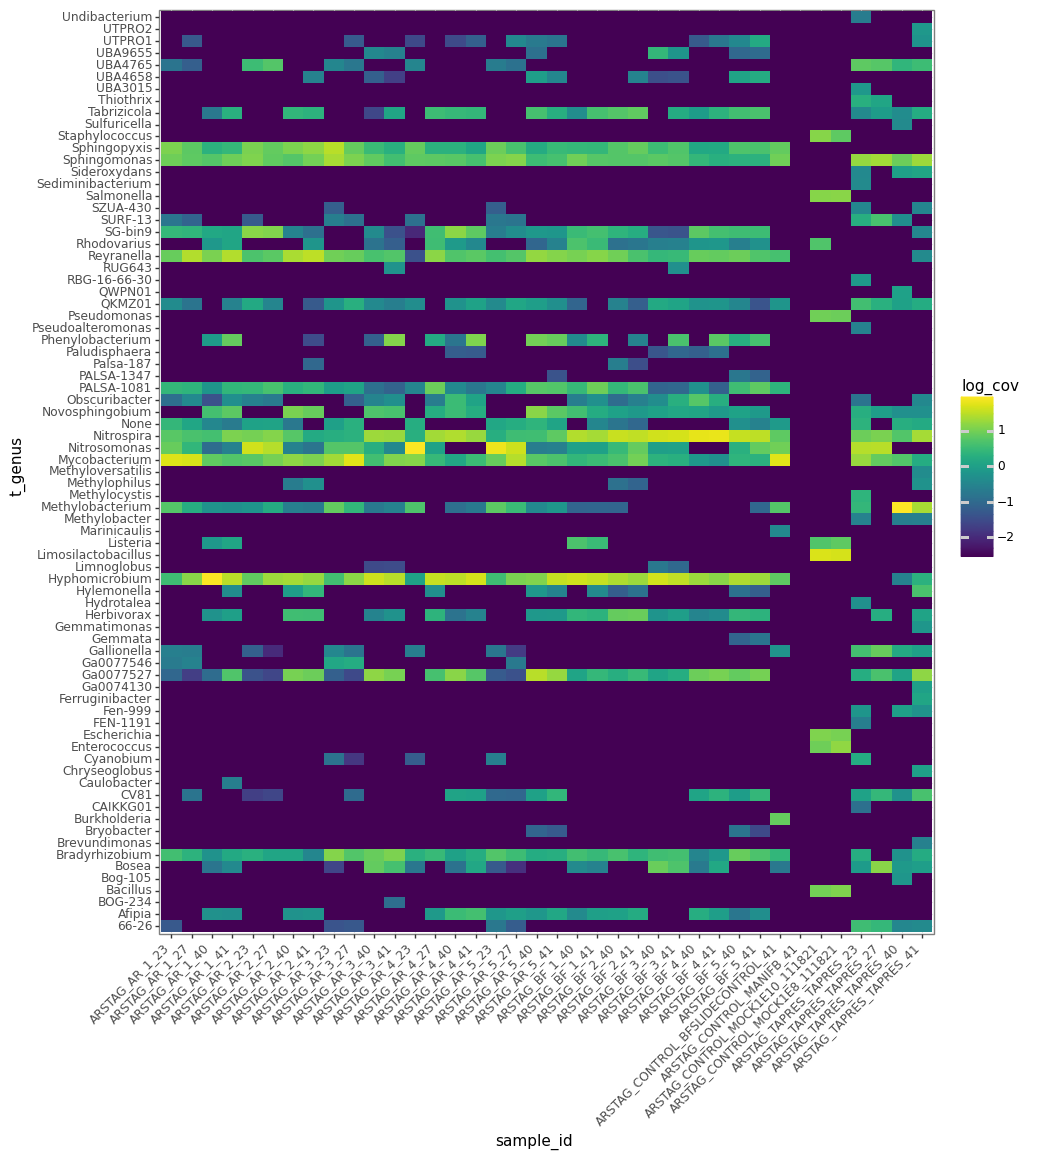

<ggplot: (8768875161031)>

In [42]:
(ggplot(genus_df, aes(x='sample_id', y='t_genus', fill='log_cov'))+
geom_tile()+
theme_bw()+
theme(axis_text_x=element_text(angle=45, hjust=1), figure_size=(10, 12)))

In [21]:
sample_id = ['ARSTAG_TAPRES_TAPRES_23', 'ARSTAG_AR_1_23', 'ARSTAG_AR_2_23', 'ARSTAG_AR_3_23', 'ARSTAG_AR_4_23', 'ARSTAG_AR_5_23', 
             'ARSTAG_TAPRES_TAPRES_27', 'ARSTAG_AR_1_27','ARSTAG_AR_2_27','ARSTAG_AR_3_27','ARSTAG_AR_4_27','ARSTAG_AR_5_27',
             'ARSTAG_TAPRES_TAPRES_40', 'ARSTAG_AR_1_40', 'ARSTAG_AR_2_40', 'ARSTAG_AR_3_40', 'ARSTAG_AR_4_40', 'ARSTAG_AR_5_40',
            'ARSTAG_BF_1_40', 'ARSTAG_BF_2_40', 'ARSTAG_BF_3_40', 'ARSTAG_BF_4_40', 'ARSTAG_BF_5_40',
            'ARSTAG_TAPRES_TAPRES_41', 'ARSTAG_AR_1_41', 'ARSTAG_AR_2_41', 'ARSTAG_AR_3_41', 'ARSTAG_AR_4_41', 'ARSTAG_AR_5_41',
            'ARSTAG_BF_1_41','ARSTAG_BF_2_41', 'ARSTAG_BF_3_41', 'ARSTAG_BF_4_41', 'ARSTAG_BF_5_41',
             'ARSTAG_CONTROL_BFSLIDECONTROL_41', 'ARSTAG_CONTROL_MANIFB_41', 'ARSTAG_CONTROL_MOCK1E10_111821','ARSTAG_CONTROL_MOCK1E8_111821']

genus_df['sample_id'] = genus_df['sample_id'].astype('category')
genus_df['sample_id'].cat.reorder_categories(['ARSTAG_TAPRES_TAPRES_23', 'ARSTAG_AR_1_23', 'ARSTAG_AR_2_23', 'ARSTAG_AR_3_23', 'ARSTAG_AR_4_23', 'ARSTAG_AR_5_23', 
             'ARSTAG_TAPRES_TAPRES_27', 'ARSTAG_AR_1_27','ARSTAG_AR_2_27','ARSTAG_AR_3_27','ARSTAG_AR_4_27','ARSTAG_AR_5_27',
             'ARSTAG_TAPRES_TAPRES_40', 'ARSTAG_AR_1_40', 'ARSTAG_AR_2_40', 'ARSTAG_AR_3_40', 'ARSTAG_AR_4_40', 'ARSTAG_AR_5_40',
            'ARSTAG_BF_1_40', 'ARSTAG_BF_2_40', 'ARSTAG_BF_3_40', 'ARSTAG_BF_4_40', 'ARSTAG_BF_5_40',
            'ARSTAG_TAPRES_TAPRES_41', 'ARSTAG_AR_1_41', 'ARSTAG_AR_2_41', 'ARSTAG_AR_3_41', 'ARSTAG_AR_4_41', 'ARSTAG_AR_5_41',
            'ARSTAG_BF_1_41','ARSTAG_BF_2_41', 'ARSTAG_BF_3_41', 'ARSTAG_BF_4_41', 'ARSTAG_BF_5_41',
             'ARSTAG_CONTROL_BFSLIDECONTROL_41', 'ARSTAG_CONTROL_MANIFB_41', 'ARSTAG_CONTROL_MOCK1E10_111821','ARSTAG_CONTROL_MOCK1E8_111821'])

0                ARSTAG_AR_1_23
1                ARSTAG_AR_1_23
2                ARSTAG_AR_1_23
3                ARSTAG_AR_1_23
4                ARSTAG_AR_1_23
                 ...           
2921    ARSTAG_TAPRES_TAPRES_41
2922    ARSTAG_TAPRES_TAPRES_41
2923    ARSTAG_TAPRES_TAPRES_41
2924    ARSTAG_TAPRES_TAPRES_41
2925    ARSTAG_TAPRES_TAPRES_41
Name: sample_id, Length: 2926, dtype: category
Categories (38, object): ['ARSTAG_TAPRES_TAPRES_23', 'ARSTAG_AR_1_23', 'ARSTAG_AR_2_23', 'ARSTAG_AR_3_23', ..., 'ARSTAG_CONTROL_BFSLIDECONTROL_41', 'ARSTAG_CONTROL_MANIFB_41', 'ARSTAG_CONTROL_MOCK1E10_111821', 'ARSTAG_CONTROL_MOCK1E8_111821']

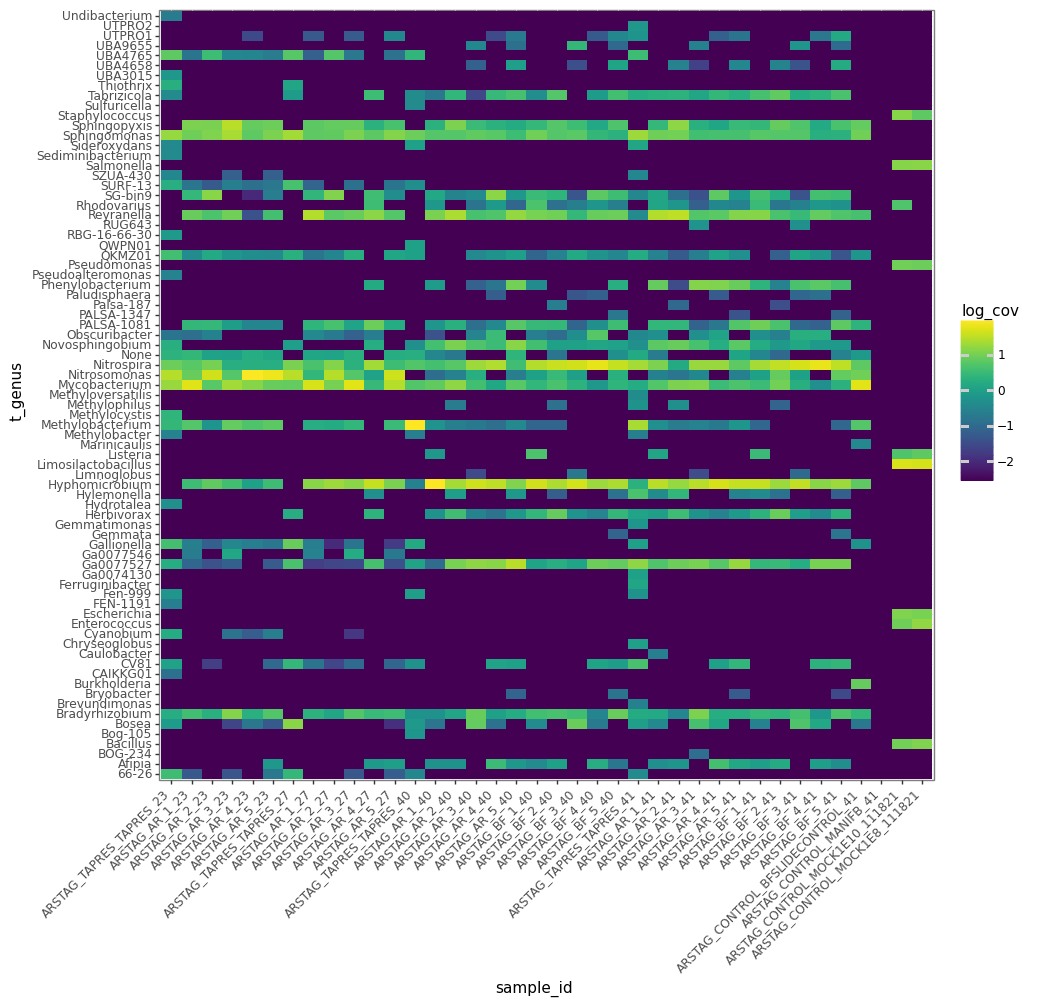

<ggplot: (8768875134681)>

In [22]:
(ggplot(genus_df, aes(x='sample_id', y='t_genus', fill='log_cov'))+
geom_tile()+
theme_bw()+
theme(axis_text_x=element_text(angle=45, hjust=1), figure_size=(10, 10)))

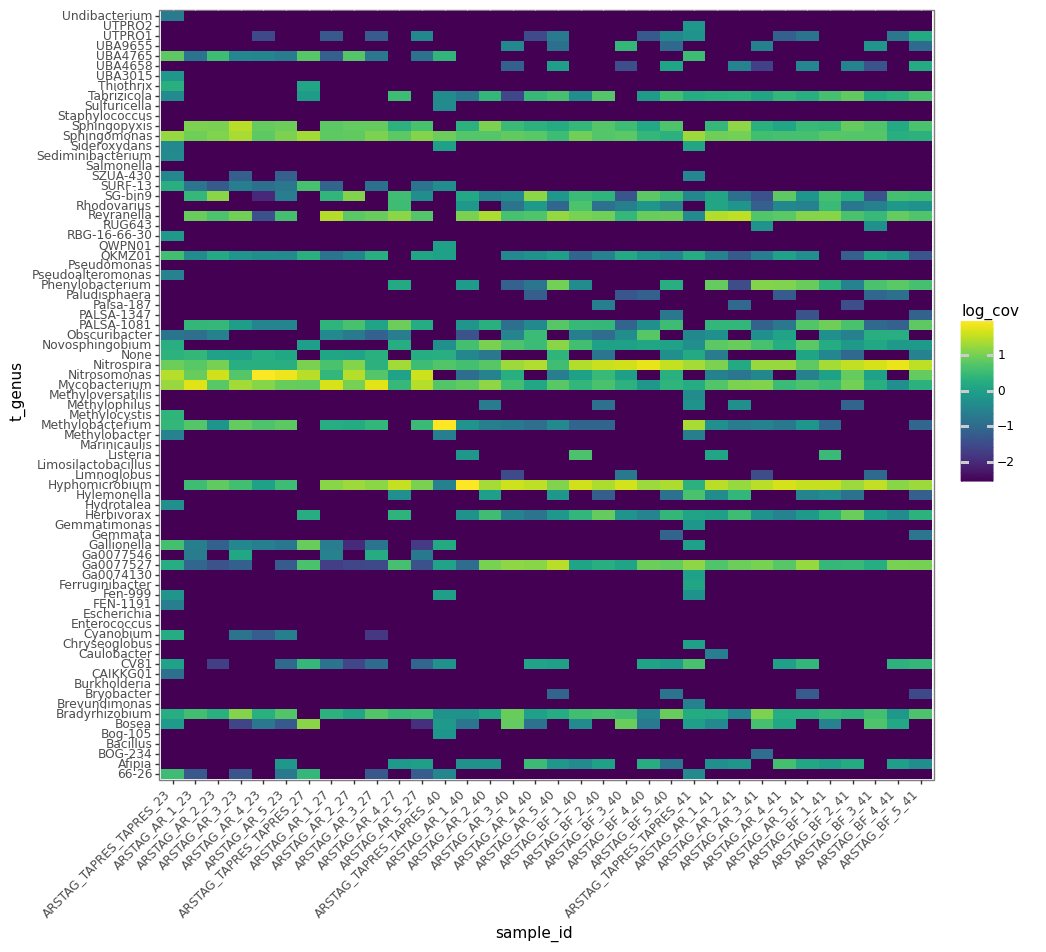

<ggplot: (8768867768751)>

In [24]:


nocontrols = genus_df[(genus_df.sample_id != "ARSTAG_CONTROL_BFSLIDECONTROL_41") & (genus_df.sample_id != "ARSTAG_CONTROL_MANIFB_41")& (genus_df.sample_id != 'ARSTAG_CONTROL_MOCK1E10_111821')& (genus_df.sample_id != 'ARSTAG_CONTROL_MOCK1E8_111821')]

(ggplot(nocontrols, aes(x='sample_id', y='t_genus', fill='log_cov'))+
geom_tile()+
theme_bw()+
theme(axis_text_x=element_text(angle=45, hjust=1), figure_size=(10, 12)))
